In [1]:
# this notebook is made for human image 
# classification of a dataset for ground truth evaluation
import matplotlib.pyplot as plt
import numpy as np
import keras
import os

Using TensorFlow backend.


Reading test ultrasound from: C:\Users\PerkLab\Desktop\HerniaModelStudy\NpyDataNoNone\x_test_seventh_128.npy
Reading test segmentation from : C:\Users\PerkLab\Desktop\HerniaModelStudy\NpyDataNoNone\y_test_seventh_128.npy

Found 3091 test ultrasound images and 3091 segmentations
(128, 128, 3)


Text(0.5, 1.0, '0.0')

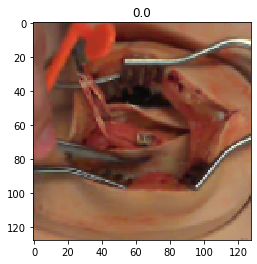

In [2]:
data_folder = r"C:\Users\PerkLab\Desktop\HerniaModelStudy\NpyDataNoNone"
test_ultrasound_file = r"x_test_seventh_128.npy"
test_segmentation_file = r"y_test_seventh_128.npy"
ultrasound_size = 128
resized_image_size = 128

test_ultrasound_fullname = os.path.join(data_folder, test_ultrasound_file)
test_segmentation_fullname = os.path.join(data_folder, test_segmentation_file)

print("Reading test ultrasound from: {}".format(test_ultrasound_fullname))
print("Reading test segmentation from : {}".format(test_segmentation_fullname))

test_ultrasound_data = np.load(test_ultrasound_fullname) 
test_segmentation_data = np.load(test_segmentation_fullname)

num_test_ultrasound = test_ultrasound_data.shape[0]
num_test_segmentation = test_segmentation_data.shape[0]

print("\nFound {} test ultrasound images and {} segmentations".format(num_test_ultrasound, num_test_segmentation))
print(test_ultrasound_data[0].shape)

imgplot = plt.imshow(test_ultrasound_data[110]/255.0)
plt.title(str(test_segmentation_data[110]))

In [3]:
import keras.utils
import scipy.ndimage


max_rotation_angle = 60
max_brightness_factor = 0.25 # adds or subtracts 20%

class UltrasoundSegmentationBatchGenerator(keras.utils.Sequence):
    
    def __init__(self,
                 x_set,
                 y_set,
                 batch_size,
                 image_dimensions=(ultrasound_size, ultrasound_size),
                 shuffle=True,
                 n_channels=3,
                 n_classes=5,
                 isTrain=True):
        self.x = x_set
        self.y = y_set
        self.batch_size = batch_size
        self.image_dimensions = image_dimensions
        self.shuffle = shuffle
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.number_of_images = self.x.shape[0]
        self.indexes = np.arange(self.number_of_images)
        self.isTrain = isTrain
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    
    def __len__(self):
        if self.isTrain:
            return int(np.floor(self.number_of_images / self.batch_size / 3))
        else:
            return int(np.floor(self.number_of_images / self.batch_size))

    
    def on_epoch_end(self):
        self.indexes = np.arange(self.number_of_images)
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size : (index+1)*self.batch_size]
        x = np.empty((self.batch_size, *self.image_dimensions, self.n_channels))
        y = np.empty((self.batch_size)) # removed dim
#         print("x.shape is {}".format(str(x.shape)))
#         print(x)
        for i in range(self.batch_size):
            
            flip_flag = np.random.randint(2) 
            if flip_flag == 1 and self.isTrain:
                x[i,:,:,:] = np.flip(self.x[batch_indexes[i],:,:,:], axis=1)
                #y[i] = np.flip(self.y[batch_indexes[i]]) # removed 2 ,; from each slice operation # changede axis 1 to 0
            else:
                x[i,:,:,:] = self.x[batch_indexes[i],:,:,:]
            y[i] = self.y[batch_indexes[i]] # removed 2 ,: from each slice operation
            
            if self.isTrain:
                brightness_multiplier = np.random.random()*max_brightness_factor*2 - max_brightness_factor + 1
                x[i, :,:,:] = brightness_multiplier * x[i, :, :, :]
#         print("x.shape is {} after flip".format(str(x.shape)))
#         print(x)
        if self.isTrain:
            angle = np.random.randint(-max_rotation_angle, max_rotation_angle) 
        else:
            angle = 0
        x_rot = scipy.ndimage.interpolation.rotate(x, angle, (2,1), False, mode="constant", cval=0, order=0)
        #y_rot = scipy.ndimage.interpolation.rotate(y, angle, (1,2), False, mode="constant", cval=0, order=0)
#         print("x_rot.shape is {} after rotation".format(str(x_rot.shape)))
#         print(x_rot)
        y_rot = y
        
        x_rot = x_rot / 255.0
        x_rot = np.clip(x_rot, 0.0, 1.0)
        #y_rot = np.clip(y_rot, 0.0, 1.0)
#         print("x_rot.shape is {} after clipping".format(str(x_rot.shape)))
#         print(x_rot)
        
        y_onehot = keras.utils.to_categorical(y_rot, self.n_classes)
        return x_rot, y_onehot

In [4]:
batch_size=61
tgen = UltrasoundSegmentationBatchGenerator(test_ultrasound_data, test_segmentation_data, batch_size, shuffle=True, isTrain=False)

In [5]:
# assume we have these variables defined properly
num_images = len(tgen)
x_set = np.empty((num_images, 128, 128, 3))
y_set = np.empty((num_images, 5))
#y_set = keras.utils.to_categorical(y_set, 6)
#print(y_set)
count = 0
correct = 0
total = 0
end=False
classes = ['Extob', 'Fat', 'Sack', 'Skin', 'Spchd']


In [6]:

print(len(tgen))
for i in range(len(tgen)):
    bx, by = tgen.__getitem__(i)
    choice = np.random.randint(0, batch_size-1)
    x = bx[choice]
    y = by[choice]
    x_set[i], y_set[i] = x, y


50


In [57]:
# each run, this cell will load a new image, and it will let you enter 
# your guess for the currently displayed image. At the end it will 
# no longer display a new image. 
try:
    fig = plt.figure(figsize = (8,8))
    img =x_set[count]
    plt.imshow(img)
except IndexError:
    print("You have labelled the whole dataset, check your results by running the bottom cell. ")
    end = True
#               0     1     2     3     4
# ANSWER HERE Extob, Fat, Sack, Skin, Spchd
human_guess = 1
# does not matter what your answer is for the first run that has no image

if count>0 and human_guess==np.argmax(y_set[count-1]):
    correct+=1
    total+=1
    print("Nice {} was correct!".format(classes[human_guess]))
elif count>0:
    total +=1
    print("{} was correct, you guessed {}".format(classes[np.argmax(y_set[count-1])], classes[human_guess]))
count+=1

You have labelled the whole dataset, check your results by running the bottom cell. 
Nice Fat was correct!


<Figure size 576x576 with 0 Axes>

In [58]:
# print results

print("The human got {} correct out of {} images. ".format(correct, total))
if total> 0:
    print("The human got {}% accuracy. ".format(correct/total*100))

The human got 50 correct out of 50 images. 
The human got 100.0% accuracy. 
